# Reproducing a simple Image Captioning

On a websites, we find many images which has no legends, or maybe, is hard to get in context when you can't see right and depends on a Screen Reader to navigate through it! Thinking of it, a good solution is to implement a Image Captioning! 

Below I'm going to reproduce the article (below quoted) that will try to get to a Image Captioner.

from https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

In [1]:
%matplotlib inline

import os
import glob
import string
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from numpy import array
from pickle import dump, load
import matplotlib.pyplot as plt

# Model-keras imports

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import (
    LSTM, Embedding, TimeDistributed, Dense, RepeatVector,
    Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
)
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

## Reviewing the dataset

For this particular example, I'm going to use the Flickr8k dataset. In this section I'm going to treat the data and let it ready to be trainned

In [3]:
# Below is the path for the file "Flickr8k.token.txt" on your disk
file = open("/data/Flickr8k/Flickr8k_text/Flickr8k.token.txt", 'r')
doc = file.read()

In [4]:
# The Text file has 5 senteces (from 0-4) for each picture, which describe it. I'm going to put this into a
# dictionary so we can use it later.

descriptions = dict()
mapping = list()

for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # take the first token as image id, the rest as description
    image_id, image_desc = tokens[0], tokens[1:]

    # extract filename from image id
    image_id = image_id.split('.')[0]

    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    
    if image_id not in mapping:
        descriptions[image_id] = list()
        mapping.append(image_id)
    descriptions[image_id].append(image_desc)

In [5]:
# An example of it
descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

In [6]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)

In [7]:
# An example of it - compare to the one above with no preprocesssing
descriptions['101654506_8eb26cfb60']

['brown and white dog is running through the snow',
 'dog is running in the snow',
 'dog running through snow',
 'white and brown dog is running through snow covered field',
 'the white and brown dog is running over the surface of the snow']

In [8]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [9]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
data = '\n'.join(lines)
file = open('descriptions.txt', 'w')
file.write(data)
file.close()

In [10]:
# open the file as read only
with open('/data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt', 'r') as file:
    doc = file.read()
    
train = list()
for line in doc.split('\n'):
    identifier = line.split('.')[0]
    train.append(identifier)
print('Dataset: %d' % len(train))

Dataset: 6000


In [11]:
with open('descriptions.txt', 'r') as file:
    doc = file.read()
    
train_descriptions = dict()
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    
    # skip images not in the set
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        
        # wrap description in tokens
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        
        # store
        train_descriptions[image_id].append(desc)

print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [12]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('preprocessed words %d ' % len(vocab))

preprocessed words 1651 


### Prepare the Images to be trained

Little explanation...

If you already have the Pikles for this job you don't need to run the following blocks, just jump straight [here](#Loading-the-pickle-to-be-used-as-Train/Test-data)

In [14]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 216s 2us/step


In [39]:
# Below path contains all the images
images = '/data/Flickr8k/Flickr8k_Dataset/'
# Create a list of all image names in the directory
imgs = glob.glob(images + '*.jpg')
print('Found %d images' % len(img))

Found 8091 images


In [16]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [17]:
# Below file conatains the names of images to be used in train data
train_images_file = '/data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in imgs: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [18]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken: {} min.".format((time()-start)/60))

Time taken in seconds = 743.1126389503479


In [19]:
# Save the bottleneck train features to disk
with open("/data/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [41]:
# Below file contains the names of images to be used in test data
test_images_file = '/data/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in imgs: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [43]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken: {} min.".format((time()-start)/60))

Time taken in seconds = 109.98106122016907


In [44]:
# Save the bottleneck test features to disk
with open("/data/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

### Loading the pickle to be used as Train/Test data

After the above preprocessing, the images will be ready in a pickle file to be use later.

In [15]:
# Take a look on what we saved!!
train_features = load(open("/data/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
test_features = load(open("/data/Pickle/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: train=6000
Photos: test=1000


In [16]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [24]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [17]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 34


In [18]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [21]:
# Load Glove vectors
glove_dir = '/data/glove6b'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_dim = 200# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
print("Matrix shape:", embedding_matrix.shape)

Matrix shape: (1652, 200)


# Design the Model

The model is explained in the image below, we have two inputs, one for the image and the other for the comment, the comment goes through an LSTM layer and the image goes through a dense layer! The images were preprocessed on a InceptionV3 as we passed by earlier.

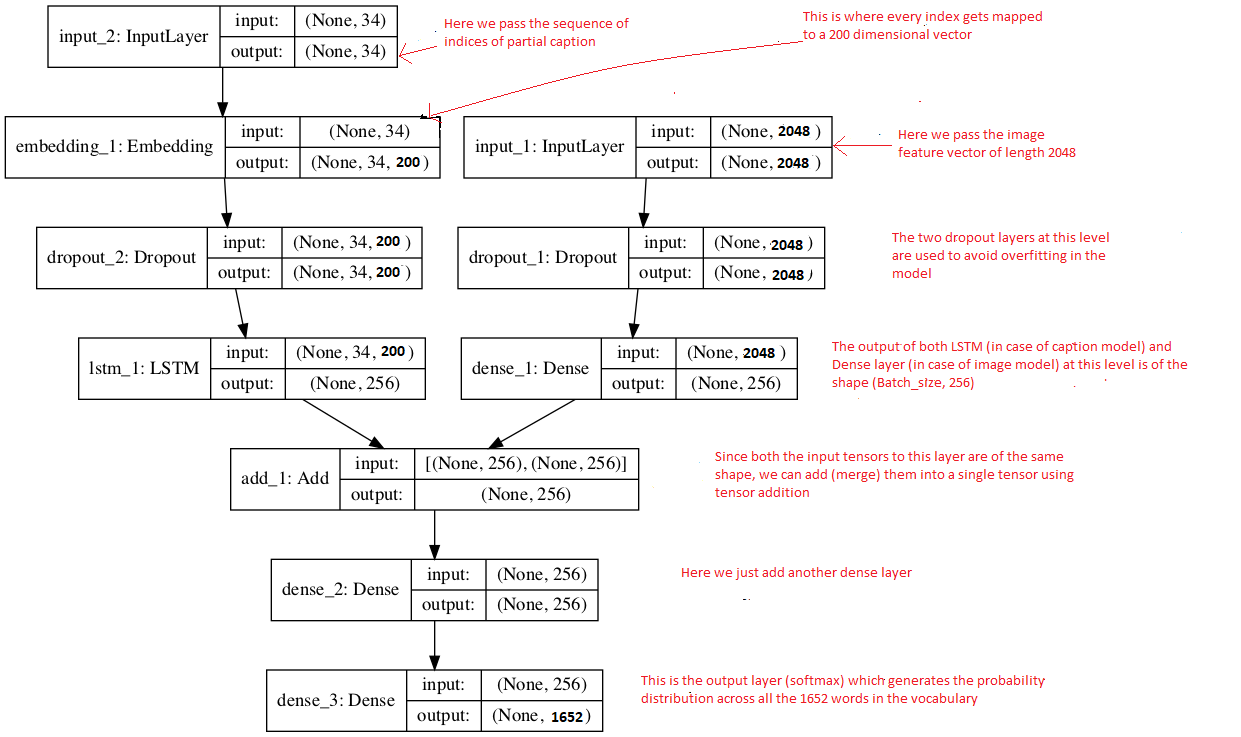

In [26]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [27]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [32]:
for i in range(epochs):
    print('[INFO] GENERAL EPOCH:', i)
    generator = data_generator(
        train_descriptions, 
        train_features, 
        wordtoix, 
        max_length, 
        number_pics_per_bath
    )
    
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('models/model_' + str(i) + '.h5')
    print('[INFO] Model saved at', 'models/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 205s 205ms/step - loss: 4.2377
Epoch 1/1
1000/1000 [==============================] - 199s 199ms/step - loss: 3.4785
Epoch 1/1
1000/1000 [==============================] - 197s 197ms/step - loss: 3.2379
Epoch 1/1
1000/1000 [==============================] - 196s 196ms/step - loss: 3.0951
Epoch 1/1
1000/1000 [==============================] - 196s 196ms/step - loss: 2.9927
Epoch 1/1
1000/1000 [==============================] - 196s 196ms/step - loss: 2.9113
Epoch 1/1
1000/1000 [==============================] - 198s 198ms/step - loss: 2.8442
Epoch 1/1
1000/1000 [==============================] - 196s 196ms/step - loss: 2.7908
Epoch 1/1
1000/1000 [==============================] - 197s 197ms/step - loss: 2.7429
Epoch 1/1
1000/1000 [==============================] - 200s 200ms/step - loss: 2.7009


### Load model

Just load the model if you already have it stored and not trained

In [ ]:
model.load_weights('models/model_9.h5')

### Use the test set to get insights of the model

Here, we are using the encoded test images previously saved, if you didn't yet, please take a look at the [section](#Prepare-the-Images-to-be-trained) where we prepare the test images and save the pickle file for it.

In [39]:
images = '/data/Flickr8k/Flickr8k_Dataset/'

with open("/data/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [36]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

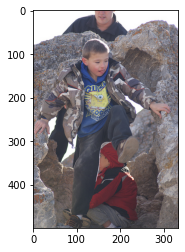

Greedy: man in red shirt is climbing rock


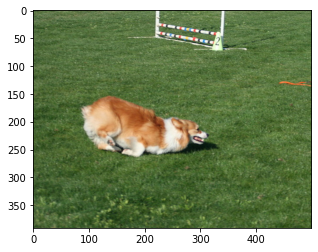

Greedy: small dog is running through the grass


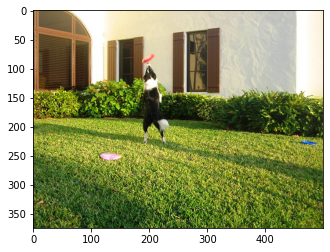

Greedy: man in white shirt and hat is sitting on bench in park


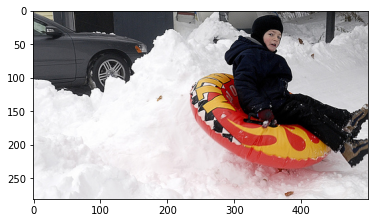

Greedy: boy in red coat is sitting in the snow


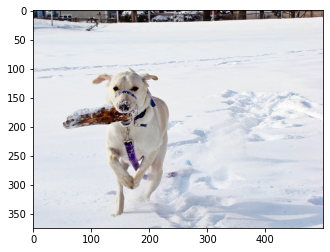

Greedy: white dog is running through the snow


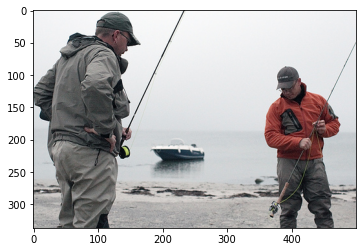

Greedy: man in black shirt is standing on the edge of boat


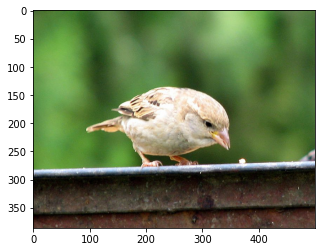

Greedy: man sits on bench with his dog


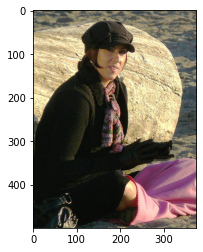

Greedy: man in red shirt and hat stands on rock


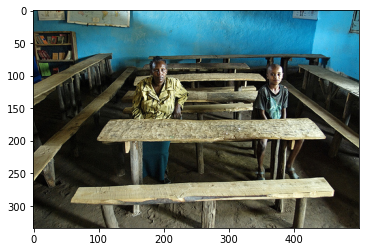

Greedy: two children are sitting on wooden bench


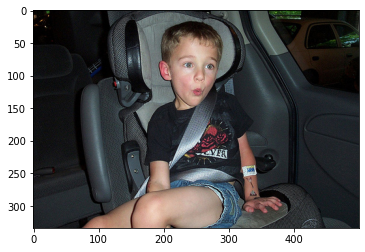

Greedy: the child is sitting on the bed


In [41]:
for i in range(10):
    pic = list(encoding_test.keys())[i]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))